# Grouping incidents caused by metheorological events

---
### Notebook Sections:

1. Utility functions
1. Data Cleaning
2. Exploratory Data Analysis
3. Clustering Incidents

### Import modules and functions

In [1]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

### Define data class to host data paths
class DATA:
    path = r'C:\Users\luisr\Desktop\Repositories\Dados\Desafio COR-Rio IV\\'
    AlertaAPI = r'http://websempre.rio.rj.gov.br/json/chuvas'

### Load data

In [2]:
catalog = pd.read_csv('Dados/incident_catalog.csv', parse_dates=True, infer_datetime_format=True)

#### Extract records of incidents of water bag formation (copy data for cleaning)

In [3]:
catalog = catalog[catalog['POP_TITULO']=="Bolsão d'água em via"].copy()
data = catalog.copy()

---
## 0. Utility functions

#### Function to format and correct street number text variable

In [4]:
from Modules.text_formatter import text_transform_pipeline, get_not_number, drop_letters, drop_space, drop_chars, split_avg

#### Plot colored and connected coordinates in 2D plane

In [5]:
from Modules.coord_plot import (
    cmaps, connect_coordinates_colored,
    min_group_size_progression_plot,
    atemporal_evolution_plot
)

---
# 1. Data Cleaning

In [6]:
data.head()

,EVENTO_ID,EVENTO_TITULO,EVENTO_DESCRICAO,EVENTO_GRAVIDADE,EVENTO_BAIRRO,STATUS,EVENTO_PRAZO,POP_TITULO,POP_DESCRICAO,evento_inicio,...,formatted_address,place_id,types,search_lat,search_lng,location_type,route,street_number,postal_code,premise
12,1258,Bolsão d'agua,R. Pinheiro Machado com Muniz Barreto - Botafogo,BAIXO,NaN,FECHADO,NaN,Bolsão d'água em via,Bolsão d'água em via,2015-09-12 20:12:00,...,"R. Muniz Barreto, 366 - Botafogo, Rio de Janei...",ChIJi27zffJ_mQARL55umyJIS4Q,['street_address'],-22.944790,-43.184068,ROOFTOP,Rua Muniz Barreto,366,22251-090,NaN
13,1259,Bolsão,"Av. Novo Rio, 3131 - Bonsucesso",BAIXO,NaN,FECHADO,NaN,Bolsão d'água em via,Bolsão d'água em via,2015-09-12 22:13:00,...,"Av. Novo Rio, 3131 - Bonsucesso, Rio de Janeir...",ChIJ-wBnkRx8mQARRqlXSftw2ds,['premise'],-22.871948,-43.256108,ROOFTOP,Avenida Novo Rio,3131,21051-051,NaN
14,1260,Bolsão,"Av. Ataulfo de Paiva, 752 - Leblon",BAIXO,NaN,FECHADO,NaN,Bolsão d'água em via,Bolsão d'água em via,2015-09-12 22:15:00,...,"Av. Ataulfo de Paiva, 750 - Leblon, Rio de Jan...",ChIJg668f63VmwARDiaRGOdZ--I,['street_address'],-22.984207,-43.223015,ROOFTOP,Avenida Ataulfo de Paiva,750,22440-033,NaN
15,1261,Bolsão,Avenida General San Martin / Praça Antero de Q...,BAIXO,NaN,FECHADO,NaN,Bolsão d'água em via,Bolsão d'água em via,2015-09-12 22:16:00,...,"Av. Ataulfo de Paiva, 750 - Leblon, Rio de Jan...",ChIJg668f63VmwARDiaRGOdZ--I,['street_address'],-22.984207,-43.223015,ROOFTOP,Avenida Ataulfo de Paiva,750,22440-033,NaN
16,1263,Bolsão d'água,"Av. Brasil, 40 - São Cristóvão",BAIXO,NaN,FECHADO,NaN,Bolsão d'água em via,Bolsão d'água em via,2015-09-13 06:30:00,...,"Av. Brasil, 35 - São Cristóvão, Rio de Janeiro...",ChIJCeABSN5-mQAR6RjL3C-eriQ,['street_address'],-22.892142,-43.216479,ROOFTOP,Avenida Brasil,35,NaN,NaN


#### Format and correct street number variable

In [7]:
not_number = get_not_number(catalog['street_number'])
not_number_corrected =  text_transform_pipeline(not_number, [drop_letters, drop_space, drop_chars, split_avg])

data.loc[not_number.index, ['street_number']] = not_number_corrected
data.dropna(subset=['street_number'], inplace=True) # drop rows where street number is missing

#### Data type conversion

In [8]:
float_cols = ['lat', 'lng', 'search_lat', 'search_lng', 'street_number']
data[float_cols] = data[float_cols].astype(float)

---
# 2. Exploratory Data Analysis

### 1. Coordinades visualization

#### Scatter plot of original coordinates

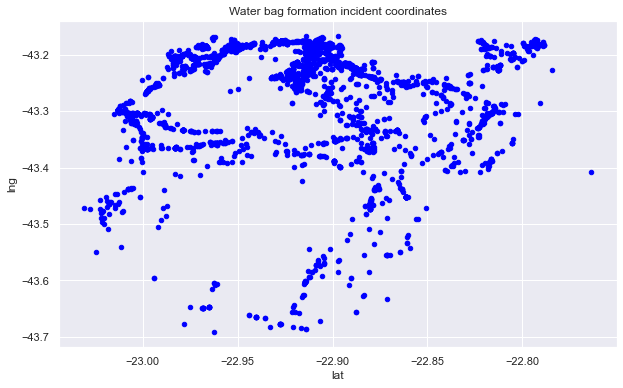

In [9]:
data.plot(
    'lat', 'lng', kind='scatter',
    c='blue', figsize=(10, 6),
    title='Water bag formation incident coordinates'
); plt.show()

### 2. Incidents per rout

#### Incidents per route - top 15

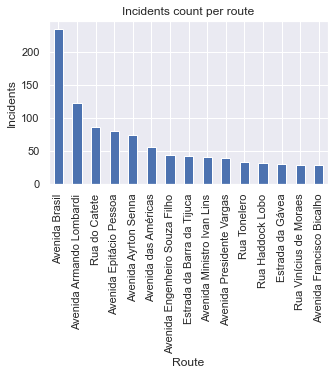

In [10]:
route_count = data['route'].value_counts().rename('Incident Count')
fig, ax = plt.subplots(figsize=(5, 3))
route_count.head(15).plot.bar(
    title='Incidents count per route',
)
ax.set(
    ylabel='Incidents',
    xlabel='Route'
)
plt.show()

#### Excluding routes with less than dinamic 'min_incidents' - Animation

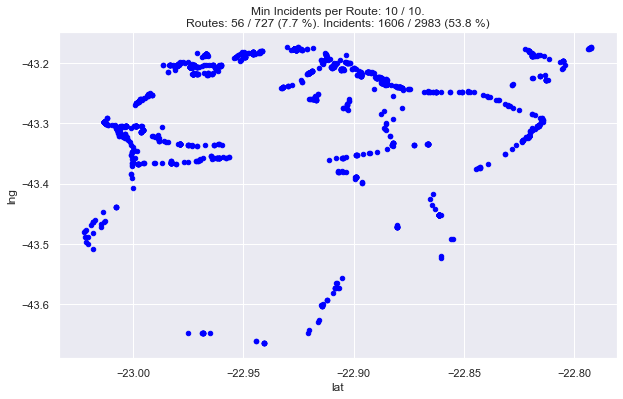

In [11]:
recurrence = min_group_size_progression_plot(
    data, ['lat', 'lng'], 'route',
    max_incidents=10, pause=0.5,
    figsize=(10, 6), color='blue'
)

#### Percentage of routes and incidents left in routes where min incidents is 8

In [12]:
min_incidents = 4; recurrence[recurrence['min_incidents']>=min_incidents]

,min_incidents,n_routes,n_incidents,p_routes (%),p_incidents (%)
4,4,158,2172,21.7,72.8
5,5,119,2016,16.4,67.6
6,6,96,1901,13.2,63.7
7,7,87,1847,12.0,61.9
8,8,74,1756,10.2,58.9
9,9,62,1660,8.5,55.6
10,10,56,1606,7.7,53.8


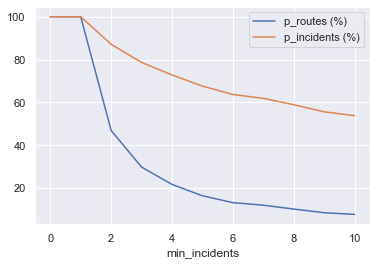

In [13]:
recurrence.set_index('min_incidents')[['p_routes (%)', 'p_incidents (%)']].plot()

#### Extracting incidents of top 50 routes

In [14]:
rec_routes = route_count[route_count >= min_incidents]
rec_data = data[data['route'].isin(rec_routes.index)]
rec_routes.tail()

Rua General Luís Mendes de Morais    4
Praça Jauru                          4
Rua Visconde de Ouro Preto           4
Rua Ibiapina                         4
Estrada do Cafundá                   4
Name: Incident Count, dtype: int64

### 3. Routes Visualization 

#### Line & Scatter plot of coordinates (colored by route and connected by address street number order)

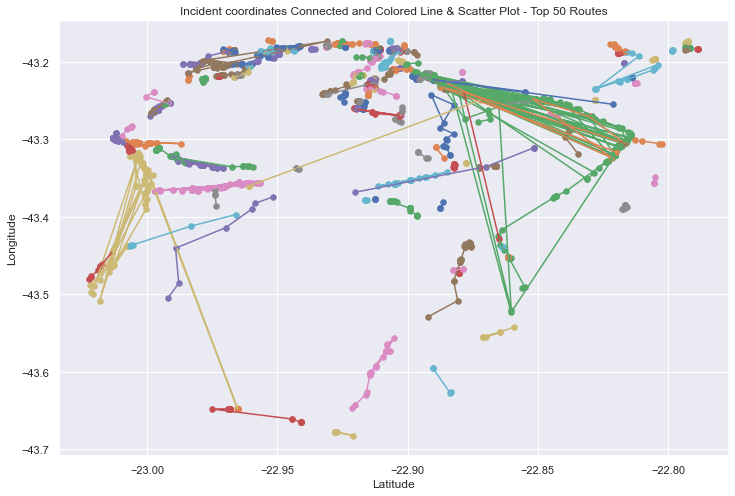

In [15]:
connect_coordinates_colored(
    rec_data['search_lat'], rec_data['search_lng'],
    rec_data['route'], rec_data['street_number'], cmap=None,
    title='Incident coordinates Connected and Colored Line & Scatter Plot - Top 50 Routes',
    figsize=(12, 8), connect=True, scatter=True
)

Obs: Street number order for records in the same route is not matching for some specific big routes.

### 4. Route and street number statistical analysis 

#### Street numbers statistical description per route (top 10)

In [16]:
number_desc = data.groupby('route')['street_number'].describe().sort_values('count', ascending=False)
number_desc.head(10)

,count,mean,std,min,25%,50%,75%,max
route,,,,,,,,
Avenida Brasil,235.0,4914.454745,8170.248330,13.0,211.0,500.0,5420.00,35025.0
Avenida Armando Lombardi,123.0,339.861789,430.901577,33.0,188.0,188.0,350.00,3652.0
Rua do Catete,87.0,175.724138,55.524285,1.0,139.0,195.0,228.00,228.0
Avenida Epitácio Pessoa,81.0,1629.308642,1413.060178,5.0,165.0,1612.0,2690.00,4800.0
Avenida Ayrton Senna,74.0,2434.189189,2388.383282,80.0,300.0,2400.0,4581.75,9001.0
Avenida das Américas,57.0,5079.501754,6514.539946,12.3,801.0,2250.0,4444.00,20035.0
Avenida Engenheiro Souza Filho,44.0,1374.454545,801.623018,10.0,586.5,1190.0,2100.00,2631.0
Estrada da Barra da Tijuca,43.0,1426.906977,634.024103,186.0,1030.0,1636.0,1716.00,3163.0
Avenida Ministro Ivan Lins,41.0,749.097561,354.292662,11.0,740.0,850.0,850.00,1770.0


#### Routes' street number range statistical description

In [17]:
number_range = ( number_desc['max'] - number_desc['min'] ).rename('Street Number Range')
number_range.describe()

count      727.000000
mean       614.483398
std       2645.060878
min          0.000000
25%          0.000000
50%          0.000000
75%        139.000000
max      35012.000000
Name: Street Number Range, dtype: float64

Obs: Street number range has good potential to segment routes

#### Routes' street number range percentiles

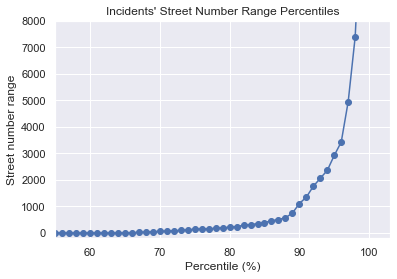

In [18]:
prcts = range(0, 101, 1)
percentiles = pd.Series(np.percentile(number_range, prcts), index=prcts)
plt.plot(percentiles, marker='o')
plt.title("Incidents' Street Number Range Percentiles")
plt.xlabel('Percentile (%)')
plt.ylabel("Street number range")
plt.xlim((55, 103))
plt.ylim((-200, 8000))
plt.show()

Obs: Street number ranges are distributed uniformly along three natural intervals. This means there are three major scales to classify streets by street number ranges of formation of water bags.


In [19]:
bins = [600, 4000]

#### Linear incident density per route - incidents per 10 m (Top 10 excluding routes with number range less than 10 meters)

In [20]:
route_numbers_density = ( route_count / number_range * 10 ).sort_values(ascending=False).rename('Incidents per 10 m')
density = pd.concat([route_numbers_density, route_count, number_range], 1); density[number_range>=7].head(10)

<ipython-input-20-fef8f96ee413>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  density = pd.concat([route_numbers_density, route_count, number_range], 1); density[number_range>=7].head(10)


,Incidents per 10 m,Incident Count,Street Number Range
Avenida Heitor Beltrão,8.000000,8,10.0
Rua do Rezende,4.666667,7,15.0
Rua José do Patrocínio,4.285714,3,7.0
Rua do Catete,3.832599,87,227.0
Rua do Passeio,3.076923,4,13.0
Avenida Professor Pereira Reis,3.000000,3,10.0
Rua da Lapa,3.000000,3,10.0
Estrada da Cancela Preta,2.857143,24,84.0
Rua Gago Coutinho,2.777778,5,18.0
Rua Leonor Pôrto,2.500000,3,12.0


c:\Users\luisr\anaconda3\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


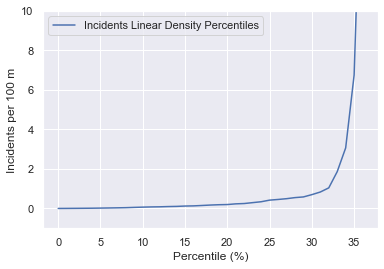

In [21]:
ax = pd.Series(np.percentile(density.iloc[:, 0], range(101)), name='Incidents Linear Density Percentiles').to_frame().plot(
    ylim=(-1, 10)
)
ax.set(ylabel='Incidents per 100 m', xlabel='Percentile (%)'), 
plt.show()

Obs: The linear density division here is below and above 10 incidents per 100 meters. Routes with more than 10 incidents per 100 meter have incidents concentrated in very small regions.

### 5. Incidents time evolution

In [22]:
file_path = 'Plots/Animations/Water Bag Formation Time Evolution JPG'
filename = '/frame_{}.jpg'

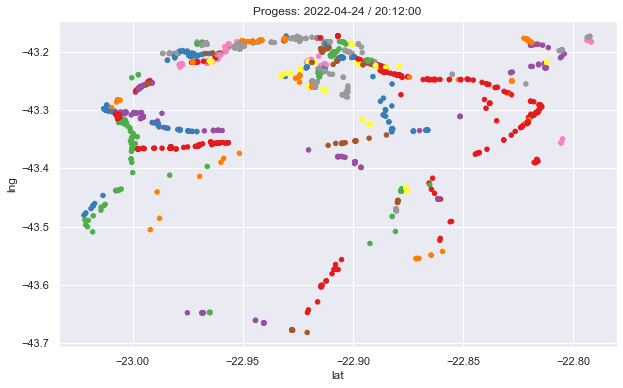

In [30]:
atemporal_evolution_plot(
    data, coord_cols=['lat', 'lng'],
    time_col='evento_inicio', color='blue',
    group_col='route', min_per_group=5,
    cmap='Set1', lut=100,
    pause=.1, frame_evolution=25, freq='W',
    figsize=(10,6),
#     path=file_path+filename
)

#### Save animation ass giff

In [23]:
from Modules.gif_builder import folder_to_gif_stream

In [24]:
gif_path = 'Plots/Animations/Water Bag Time Evolution.gif'

#  folder_to_gif_stream(file_path, gif_path, duration=0.3)

---
# 3.Clustering Incidents

##### Planning:
1. Cluster all points together
2. Cluster by street number
3. Cluster only routes with more than min_incidents
4. Cluster only routes with more than min_incident_density
5. Cluster only routes with number range above min_street_number_range

#### 0.1 Cluster processing and plot function

In [25]:
def filter_group_size(data, group_col, min_members=10):
    label_cnt = data[group_col].value_counts()
    top_labels = label_cnt[label_cnt > min_members].index
    top_msk = data[group_col].isin(top_labels)
    return data[top_msk]

def min_samples_clusters_animation(
    data, group_col, max_samples_stop=0.5, freq=0.1,
    coord_cols=['lat', 'lng'], order_col='street_number',
    connect=False, scatter=True,
    cmap=None, figsize=(20, 12),
    title='Incident coordinates Connected and Colored Line & Scatter Plot',
):
    
    label_cnt = data[group_col].value_counts()
    max_samples = label_cnt.max()
    min_samples = label_cnt.min()
    size_range = max_samples - min_samples
    
    if type(max_samples_stop) is float:
        min_samples_i = min_samples + (np.arange(0, max_samples_stop, freq) * size_range).round(0)
    elif type(max_samples_stop) is int:
        min_samples_i = np.arange(min_samples, max_samples_stop+1, freq)
        
    for min_samples in min_samples_i:

        top_data = filter_group_size(data, group_col=group_col, min_members=min_samples)

        co(wait=True)
        connect_coordinates_colored(
            top_data[coord_cols[0]], top_data[coord_cols[1]],
            top_data[group_col], top_data[order_col], cmap=cmap,
            connect=connect, scatter=scatter,
            title=title,
            figsize=figsize,
        )

#### 0.2 Setting automatic clustering algorithms

In [26]:
import sklearn.cluster as cluster
from sklearn.preprocessing import MinMaxScaler as mms, LabelEncoder as le

dbscan = cluster.DBSCAN(eps=0.005, min_samples=3)
optics = cluster.OPTICS(min_samples=4, max_eps=0.05)
mean = cluster.MeanShift(bandwidth=0.015, cluster_all=False, max_iter=1000)
# aff = cluster.AffinityPropagation(damping=.6, max_iter=1000, convergence_iter=10, random_state=0, verbose=1)

algs = [dbscan, optics, mean]#, aff]

##### Algorithm source code and examples

In [27]:
# a = algs[3]; a?

### 1. Clustering by geodetic coordinates

##### Fit different algorithms

In [28]:
coords = mms().fit_transform(data[['lat', 'lng']])
for i, alg in enumerate(algs):
    print(f'{i+1}/{len(algs)} - Algorithm running...'); alg.fit(coords); co(wait=True)
print('Done!')

Done!


#### Compare performance of algorithms

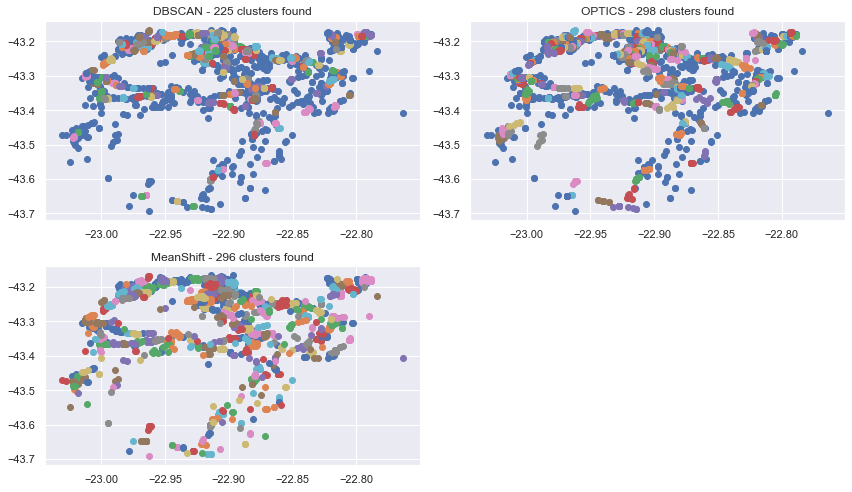

In [29]:
fig = plt.figure(figsize=(12, 7), tight_layout=True)
axs = [fig.add_subplot(2, 2, i) for i in range(1, len(algs)+1)]
for ax, alg in zip(axs, algs):
    for label in np.unique(alg.labels_):
        msk = alg.labels_==label
        ax.scatter(data['lat'][msk], data['lng'][msk]) #, c=alg.labels_)
    ax.set(title=f'{type(alg).__name__} - {len(np.unique(alg.labels_))} clusters found')
plt.show()

#### Best auto algorithm

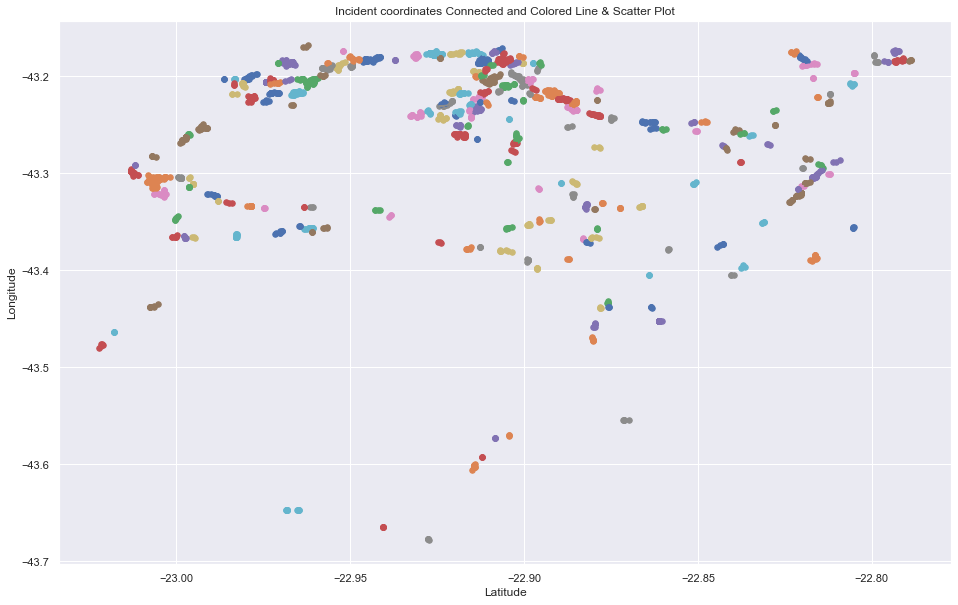

In [30]:
sel_alg = 0

data['label'] = algs[sel_alg].labels_
in_data = data[data['label'] != -1] # Excluding outlier samples

connect_coordinates_colored(
    in_data['lat'], in_data['lng'],
    in_data['label'], in_data['street_number'], cmap=None,
    title='Incident coordinates Connected and Colored Line & Scatter Plot',
    figsize=(16, 10), connect=True
)

#### Filter clusters by minimum number of samples

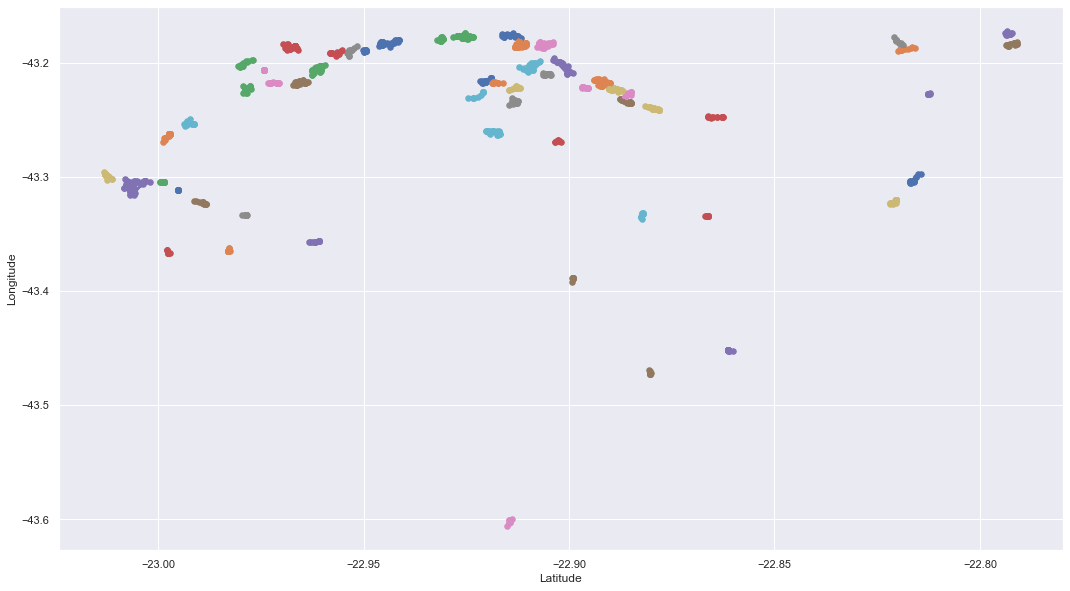

In [31]:
top_data = filter_group_size(in_data, group_col='label', min_members=10)

co(wait=True)
connect_coordinates_colored(
    top_data['lat'], top_data['lng'],
    top_data['label'], top_data['street_number'],
    cmap=None, figsize=(18, 10),
    connect=True,
    #     title=title,
)

#### Excluding clusters by dinamic mininum number of samples per cluster - Animation

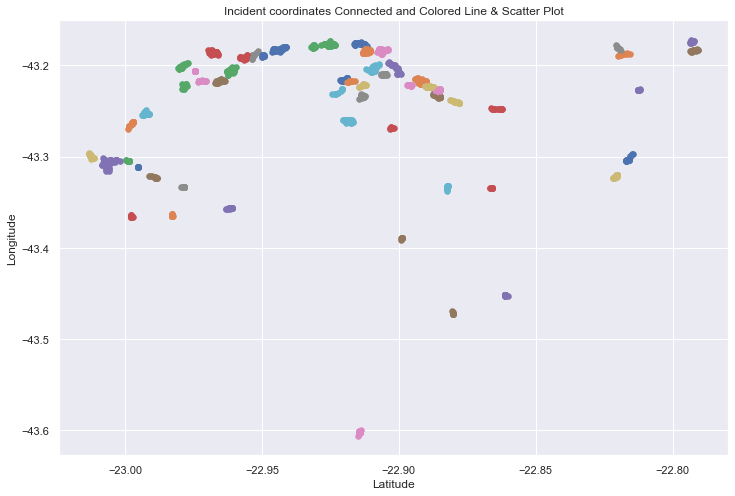

In [32]:
min_samples_clusters_animation(in_data, 'label', max_samples_stop=10, freq=1, figsize=(12, 8), connect=True)

### 2. Evaluate cluster result

#### Number of clusters with at least 'min_samples'

In [33]:
len(top_data['label'].unique())

57

#### Cluster size distribution

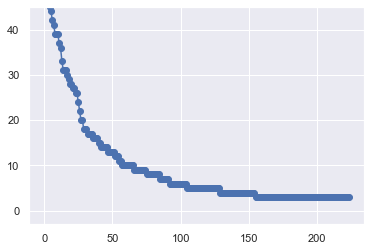

In [34]:
in_data['label'].value_counts().reset_index(drop=True).plot(ylim=(-3, 45), marker='o'); plt.show()

#### Routes per cluster

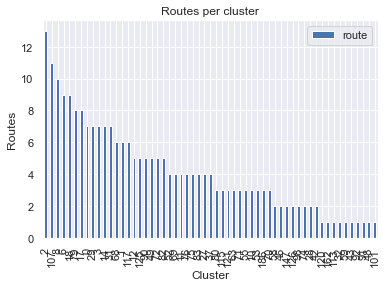

In [35]:
ax = top_data.groupby(['label'])[['route']].nunique().sort_values('route', ascending=False).plot.bar()
ax.set(title='Routes per cluster', ylabel='Routes', xlabel='Cluster')
plt.show()

#### Routes per cluster distribution

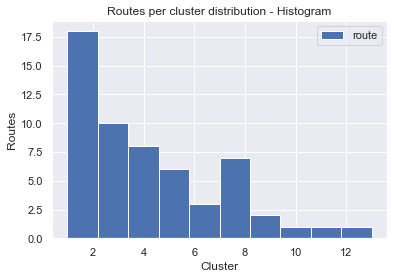

In [36]:
ax = top_data.groupby(['label'])[['route']].nunique().sort_values('route', ascending=False).plot.hist()
ax.set(title='Routes per cluster distribution - Histogram', ylabel='Routes', xlabel='Cluster')
plt.show()

### 3. Visualize clusters in folium map

In [37]:
import folium
from Modules.mapper import plot_markers

In [42]:
Map = folium.Map(
    location=[-22.9037, -43.4276], zoom_start=10,
    width='100%', height='100%', tiles='Stamen Terrain'
)

Map, LE = plot_markers(
    Map, top_data, radius=3,
    coord_cols=['lat', 'lng'],
    group_col='label', cmap='tab20',
    exclude=[], touch_coord=True, return_encoder=True
)

Map

### 4. Save best cluster result

Cluster info:
1. Cluster label
2. Cluster representative street
3. Cluster Centroid
4. Cluster box
5. Cluster box center
6. Cluster radius

In [43]:
from Modules.geometric_properties import clusters_geometry

clusters = data.set_index('EVENTO_ID')[['label']]

#### Join clusters' representative routes

In [44]:
cluster_route_cnt = data.groupby(['label', 'route'])[['EVENTO_ID']].count().sort_values(['label', 'EVENTO_ID'], ascending=[True, False])
cluster_top_routes = cluster_route_cnt.reset_index('route').groupby('label')['route'].first().to_dict()
cluster_route_map = lambda label: cluster_top_routes[label]

clusters['main_route'] = list(map(cluster_route_map, clusters['label']))

#### Join geometric properties

In [45]:
geometry = clusters_geometry(
    data['lat'], data['lng'], clusters['label'],
    include_box=True, include_center_radius=True
)

clusters = clusters.join(geometry)

#### Save cluster labels and geometric properties

In [47]:
# clusters.to_csv('Dados/incident_clusters.csv', index=True)

clusters.head()

,label,main_route,lat_centroid,lng_centroid,lat_min,lat_max,lng_min,lng_max,lat_center,lng_center,horizontal_perimeter,vertical_perimeter,radius
EVENTO_ID,,,,,,,,,,,,,
1258,0,Praia de Botafogo,-22.944533,-43.182800,-22.946246,-22.941320,-43.185848,-43.180029,-22.943783,-43.182939,545.554345,596.804890,298.402445
1259,-1,Avenida das Américas,-22.908780,-43.340046,-23.031019,-22.763640,-43.692051,-43.166944,-22.897329,-43.429498,29610.228706,53875.861927,26937.930964
1260,-1,Avenida das Américas,-22.908780,-43.340046,-23.031019,-22.763640,-43.692051,-43.166944,-22.897329,-43.429498,29610.228706,53875.861927,26937.930964
1261,-1,Avenida das Américas,-22.908780,-43.340046,-23.031019,-22.763640,-43.692051,-43.166944,-22.897329,-43.429498,29610.228706,53875.861927,26937.930964
1263,1,Avenida Rio de Janeiro,-22.892384,-43.216725,-22.893985,-22.889982,-43.220700,-43.214200,-22.891984,-43.217450,443.346533,666.925550,333.462775


### 5. Analysis of clusters' geometry results

In [48]:
top_clusters = clusters.loc[top_data['EVENTO_ID']]

#### Samples per cluster

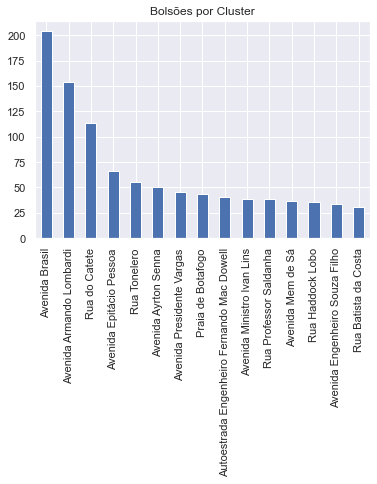

In [50]:
ax = top_clusters['main_route'].value_counts().head(15).plot.bar(title='Bolsões por Cluster'); plt.show()

#### Cluster radius statistical description

In [56]:
(top_clusters[['radius']]).describe()

,radius
count,1574.000000
mean,293.541305
std,183.088563
min,5.614172
25%,181.305257
50%,268.385599
75%,343.504509
max,707.378852


In [58]:
from Modules.mapper import plot_markers, draw_circles, draw_rectangles

In [61]:
areas = clusters.groupby('label').first().loc[top_data['label'].unique()]

In [ ]:
Map = folium.Map(
    location=[-22.9037, -43.4276], zoom_start=10,
    width='80%', height='80%', tiles='Stamen Terrain'
)

Map, LE = plot_markers(
    Map, top_data, radius=3,
    coord_cols=['lat', 'lng'],
    group_col='label', cmap='tab20',
    exclude=[], touch_coord=True, return_encoder=True
)

Map = draw_circles(
    Map, areas,
    loc=['lat_center', 'lng_center'], radius='radius',
    popup='main_route', tooltip='main_route',
    cmap='tab20', lut=len(areas), LE=LE,
    stroke=True, weight=4, fill=True,
    fill_color=None, fill_opacity=.3
)

Map = draw_rectangles(
    Map, areas,
    loc=[['lat_min', 'lng_min'], ['lat_max', 'lng_max']],
    popup='main_route', tooltip='main_route',
    cmap='tab20', lut=len(areas), LE=LE,
    stroke=True, weight=3, fill=True,
    fill_color=None, fill_opacity=.3
)

In [522]:
Map